# Advanced Analytics

In [ ]:
from google.colab import files
files.upload()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Replace with your file path
df = pd.read_excel("Real_estate_Hanoi_clean.xlsx")

# Quick peek
df.head()

# 1. A Descriptive Clustering

In [ ]:
#1 Feature Matrix
features = df[["unit_price", "area_avg", "dist_cbd_km"]].copy()
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(features)


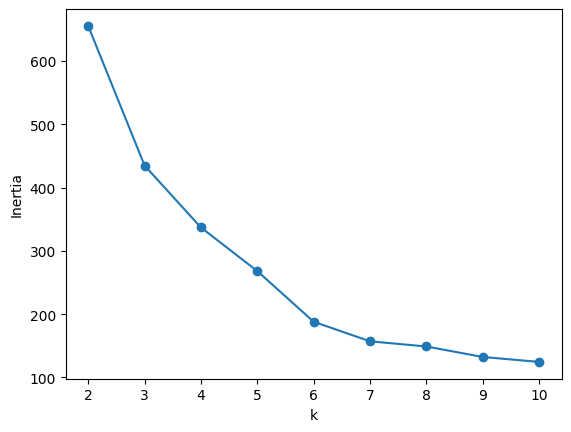

In [ ]:
# 2 K-Means (baseline)
# Elbow plot
inertia = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    inertia.append(km.inertia_)
plt.plot(range(2,11), inertia, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.show()


In [ ]:
k_opt = 3          # silhouette score nearest to 1
km = KMeans(n_clusters=k_opt, random_state=42)
df["cluster_km"] = km.fit_predict(X_scaled)
print("Silhouette:", silhouette_score(X_scaled, df["cluster_km"]))


Silhouette: 0.7186685104068085


In [ ]:
#DBSCAN (density-based)
db = DBSCAN(eps=1.1, min_samples=6).fit(X_scaled)
df["cluster_db"] = db.labels_
print("Noise points:", (df["cluster_db"]==-1).sum())

Noise points: 16


In [ ]:
from sklearn.neighbors import NearestNeighbors


In [ ]:
k = 5                # bằng min_samples
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

In [ ]:
k_dist = np.sort(distances[:, k-1])   # k-1 vì chỉ số bắt đầu từ 0


In [ ]:
#Test to choose the most suitable eps and min_samples
configs = [(0.9,5),(1.0,6),(1.05,6),(1.1,6)]
for eps, ms in configs:
    labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_scaled)
    score  = silhouette_score(X_scaled, labels)
    noise  = (labels == -1).mean()
    print(f"eps={eps:<4} min={ms}  |  Silhouette={score:.3f}  |  Noise={noise:.2%}")

    #Choose eps = 1.10, min_samples = 6


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# 1) Chạy DBSCAN với thông số bạn chọn
db = DBSCAN(eps=1.1, min_samples=6).fit(X_scaled)
labels = db.labels_

# 2) Tính Silhouette
sil = silhouette_score(X_scaled, labels)     # mặc định metric='euclidean'
print(f"Silhouette score (eps=1.1, min_samples=6): {sil:.3f}")


Silhouette score (eps=1.1, min_samples=6): 0.673


In [ ]:
base_feats = ["unit_price", "area_avg", "dist_cbd_km"]   # already engineered


In [ ]:
#Scale the core variables
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(df[base_feats])

In [ ]:
#DBSCAN with parameters
db = DBSCAN(eps=1.10,        # radius in **scaled** units (after StandardScaler!)
            min_samples=6).fit(X_scaled)

df["cluster_db"] = db.labels_
noise_pct = (df.cluster_db == -1).mean()
print(f"Noise share: {noise_pct:.1%}")

Noise share: 5.2%


In [ ]:
#Profile clusters
cluster_summary = (
    df.groupby("cluster_db")[base_feats]
      .agg(["count","mean","median"])
      .round(1)
      .style.background_gradient(cmap="YlGn")
)
cluster_summary

# 2.  Predictive Modelling – Gradient‑Boosted Regression


In [ ]:
#Build X/y
X = pd.get_dummies(
        df[["area_avg","dist_cbd_km", "district"]], # Include "district" for dummies
        columns=["district"],  # Specify the column to create dummies from
        drop_first=True
    ).astype(float)
y = df["unit_price"]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, 10)
)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


In [ ]:
gbr = GradientBoostingRegressor(random_state=42)
grid = GridSearchCV(
    gbr,
    param_grid = {
        "n_estimators":[300,500,700],
        "learning_rate":[0.05,0.1],
        "max_depth":[2,3,4],
        "subsample":[0.8,1.0]
    },
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)
grid.fit(X_train, y_train)
best = grid.best_estimator_
print("Best params:", grid.best_params_)

Best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'subsample': 1.0}


In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

pred = best.predict(X_test)
print("MAE:", round(mean_absolute_error(y_test, pred), 2), "mil VND")
print("R² :", round(r2_score(y_test, pred), 3)) # Round the r2_score result

MAE: 28.29 mil VND
R² : 0.055


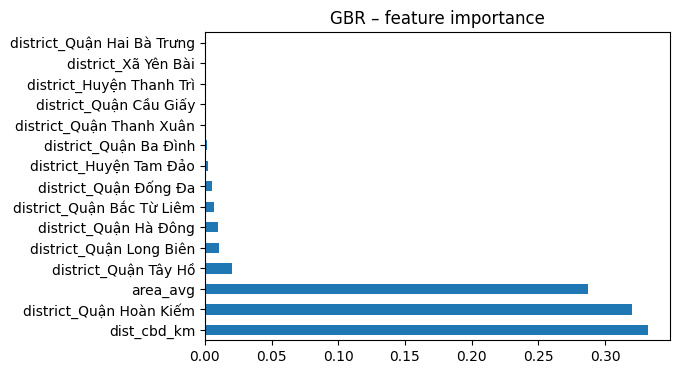

In [ ]:
(pd.Series(best.feature_importances_, index=X.columns)
   .sort_values(ascending=False)
   .head(15)
   .plot(kind="barh", figsize=(6,4)))
plt.title("GBR – feature importance")
plt.show()

# 3.  Profitability Scenario – Monte‑Carlo

In [ ]:
# Example new site
candidate = {
    "area_avg": 80,
    "dist_cbd_km": 9.5,
    "district": "Nam Từ Liêm",
}

In [ ]:
X_new = pd.DataFrame([candidate])
X_new = pd.get_dummies(X_new).reindex(columns=X.columns, fill_value=0).astype(float)
sale_price_est = best.predict(X_new)[0]
print(f"Estimated sale price: {sale_price_est:.1f} mil VND/m²")

Estimated sale price: 28.9 mil VND/m²


In [ ]:
#Set uncertainty assumptions
n_sim = 10_000
rng    = np.random.default_rng(42)

# costs in mil VND/m²
mean_cost, sd_cost = 14, 1.2
# sale‑price uncertainty ±5 %
price_sd_pct = 0.05


In [ ]:
#Run simulations
sim_cost  = rng.normal(mean_cost,  sd_cost,           n_sim)
sim_price = rng.normal(sale_price_est, sale_price_est*price_sd_pct, n_sim)
sim_profit = sim_price - sim_cost

Expected profit: 14.9 mil VND/m²
Loss probability: 0.0%


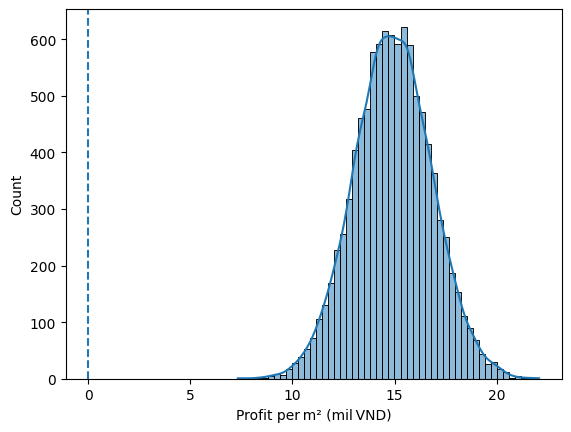

In [ ]:
#Risk metrics & plot
loss_prob = (sim_profit < 0).mean()
exp_ppm   = sim_profit.mean()

print(f"Expected profit: {exp_ppm:.1f} mil VND/m²")
print(f"Loss probability: {loss_prob:.1%}")

sns.histplot(sim_profit, bins=50, kde=True)
plt.axvline(0, ls="--"); plt.xlabel("Profit per m² (mil VND)"); plt.show()